In [4]:
!pip install datasets nltk matplotlib seaborn


In [5]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


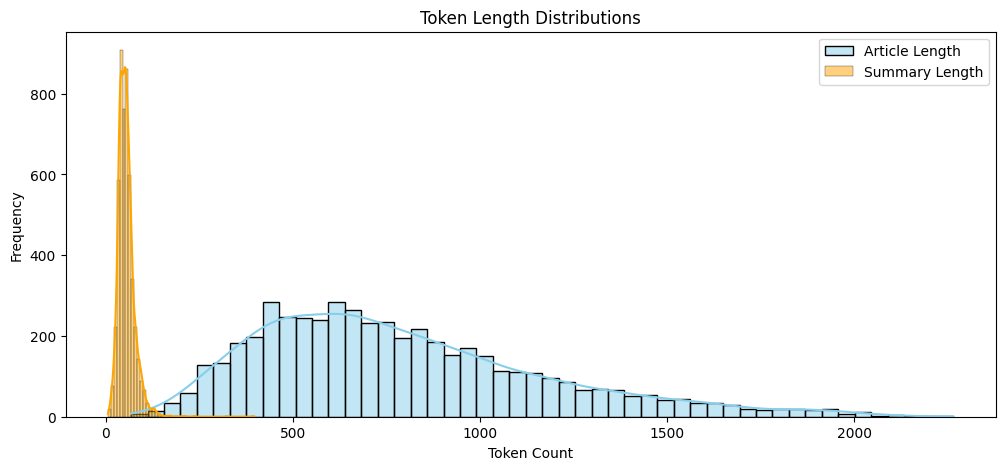

Average Article Length: 790.124
Average Summary Length: 54.8954


,article,highlights
0,Nasa has warned of an impending asteroid pass ...,2004 BL86 will pass about three times the dist...
1,"BAGHDAD, Iraq (CNN) -- Iraq's most powerful Su...","Iraqi Islamic Party calls Quran incident ""blat..."
2,By . David Kent . Andy Carroll has taken an un...,Carroll takes to Instagram to post selfie ahea...
3,Los Angeles (CNN) -- Los Angeles has long been...,Pop stars from all over Europe are setting the...
4,London (CNN) -- Few shows can claim such an au...,NEW: Young athletes light the Olympic cauldron...


In [7]:
import pandas as pd
from datasets import load_dataset
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.tokenize import word_tokenize

nltk.download("punkt")

base_path = "/content/drive/MyDrive/Datasets/"
train_0 = pd.read_parquet(base_path + "train-00000-of-00003.parquet")
train_1 = pd.read_parquet(base_path + "train-00001-of-00003.parquet")
train_2 = pd.read_parquet(base_path + "train-00002-of-00003.parquet")

# Merge
train_df = pd.concat([train_0, train_1, train_2], ignore_index=True)

# EDA Sample (optional)
train_df = train_df.sample(n=5000, random_state=42).reset_index(drop=True)

# Lengths
train_df["article_len"] = train_df["article"].apply(lambda x: len(word_tokenize(x)))
train_df["summary_len"] = train_df["highlights"].apply(lambda x: len(word_tokenize(x)))

# Plot
plt.figure(figsize=(12, 5))
sns.histplot(train_df["article_len"], bins=50, kde=True, color="skyblue", label="Article Length")
sns.histplot(train_df["summary_len"], bins=50, kde=True, color="orange", label="Summary Length")
plt.legend()
plt.title("Token Length Distributions")
plt.xlabel("Token Count")
plt.ylabel("Frequency")
plt.show()

# Summary statistics
print("Average Article Length:", train_df["article_len"].mean())
print("Average Summary Length:", train_df["summary_len"].mean())

# Preview
train_df[["article", "highlights"]].head()


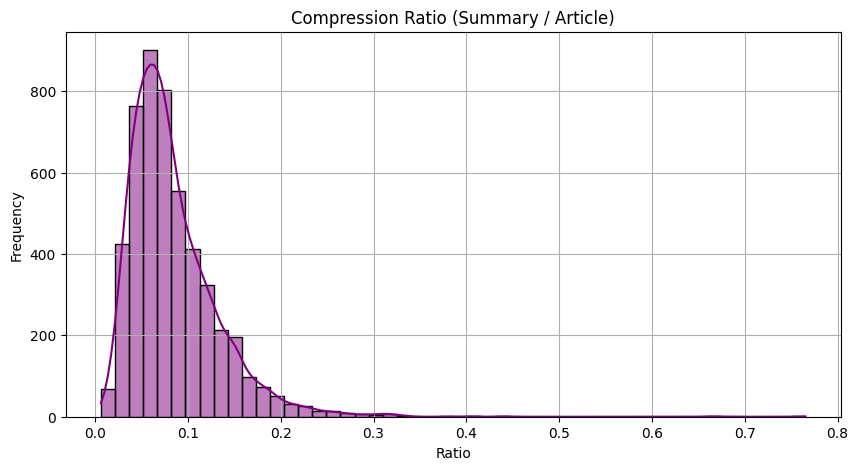

Null counts:
 article              0
highlights           0
id                   0
article_len          0
summary_len          0
compression_ratio    0
dtype: int64

Duplicate rows: 0

Descriptive stats for article and summary lengths:
       article_len  summary_len  compression_ratio
count  5000.000000  5000.000000        5000.000000
mean    790.124000    54.895400           0.084087
std     382.993925    21.966642           0.048147
min      68.000000     6.000000           0.006164
25%     500.000000    40.000000           0.051662
50%     717.000000    52.000000           0.073099
75%    1004.000000    64.000000           0.105620
max    2265.000000   397.000000           0.765403


In [8]:
# Compression ratio
train_df["compression_ratio"] = train_df["summary_len"] / train_df["article_len"]

# Distribution of compression ratio
plt.figure(figsize=(10, 5))
sns.histplot(train_df["compression_ratio"], bins=50, kde=True, color="purple")
plt.title("Compression Ratio (Summary / Article)")
plt.xlabel("Ratio")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

# Null and duplicate checks
print("Null counts:\n", train_df.isnull().sum())
print("\nDuplicate rows:", train_df.duplicated(subset=["article", "highlights"]).sum())

# Descriptive statistics
print("\nDescriptive stats for article and summary lengths:")
print(train_df[["article_len", "summary_len", "compression_ratio"]].describe())


In [9]:
!pip install transformers

from transformers import T5Tokenizer

tokenizer = T5Tokenizer.from_pretrained("t5-small")

max_input_length = 1024
max_target_length = 128

def preprocess_function(examples):
    inputs = ["summarize: " + doc for doc in examples["article"]]
    model_inputs = tokenizer(inputs, max_length=max_input_length, truncation=True, padding="max_length")

    labels = tokenizer(examples["highlights"], max_length=max_target_length, truncation=True, padding="max_length")
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

# Convert to Dataset
from datasets import Dataset
tokenized_dataset = Dataset.from_pandas(train_df[["article", "highlights"]])
tokenized_dataset = tokenized_dataset.map(preprocess_function, batched=True, remove_columns=["article", "highlights"])

# Check structure
tokenized_dataset


Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 5000
})

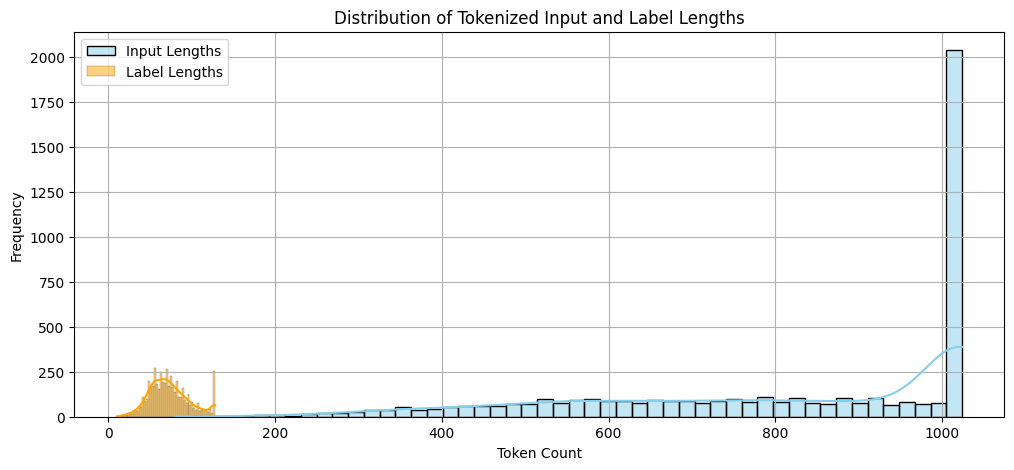

,input_length,label_length
count,5000.00000,5000.000000
mean,813.62520,73.350400
std,232.46541,24.217062
min,80.00000,10.000000
25%,630.75000,56.000000
50%,894.00000,70.000000
75%,1024.00000,88.000000
max,1024.00000,128.000000


In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Create stats on input_ids and labels
input_lengths = [len([tok for tok in sample if tok != tokenizer.pad_token_id]) for sample in tokenized_dataset["input_ids"]]
label_lengths = [len([tok for tok in sample if tok != tokenizer.pad_token_id]) for sample in tokenized_dataset["labels"]]

length_df = pd.DataFrame({
    "input_length": input_lengths,
    "label_length": label_lengths
})

# Plot
plt.figure(figsize=(12, 5))
sns.histplot(length_df["input_length"], bins=50, kde=True, color="skyblue", label="Input Lengths")
sns.histplot(length_df["label_length"], bins=50, kde=True, color="orange", label="Label Lengths")
plt.legend()
plt.title("Distribution of Tokenized Input and Label Lengths")
plt.xlabel("Token Count")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

# Descriptive stats
length_df.describe()


In [11]:
!pip install --upgrade transformers --quiet

In [12]:
import transformers
print(transformers.__version__)

4.52.4


In [13]:
!pip uninstall -y transformers


Found existing installation: transformers 4.52.4
Uninstalling transformers-4.52.4:
  Successfully uninstalled transformers-4.52.4


In [14]:
!pip cache purge

Files removed: 12


In [15]:
!pip install transformers==4.41.1 --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 kB 2.7 MB/s eta 0:00:00
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/base_command.py", line 179, in exc_logging_wrapper
    status = run_func(*args)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/req_command.py", line 67, in wrapper
    return func(self, options, args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/commands/install.py", line 377, in run
    requirement_set = resolver.resolve(
                      ^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/resolution/resolvelib/resolver.py", line 95, in resolve
    result = self._result = resolver.resolve(
                            ^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_vendor/resolvelib/resolvers.py", line 546, in resolve
    state = resolution.resolve(requ

Exception ignored in: <function tqdm.__del__ at 0x7b86014cae80>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/tqdm/std.py", line 1147, in __del__
    def __del__(self):

KeyboardInterrupt: 


In [16]:
import transformers
print(transformers.__version__)

4.52.4


In [17]:
from transformers import (
    T5Tokenizer,
    T5ForConditionalGeneration,
    TrainingArguments,
    Trainer
)


In [18]:

# Load pre-trained model
model = T5ForConditionalGeneration.from_pretrained("t5-small")
tokenizer = T5Tokenizer.from_pretrained("t5-small")

training_args = TrainingArguments(
    output_dir="./t5_summarizer",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=3,
    logging_dir="./logs",
    save_total_limit=2,
    save_strategy="epoch",
    learning_rate=3e-4,
    weight_decay=0.01,
    fp16=True,
    report_to="none"
)


# Split dataset
tokenized_dataset = tokenized_dataset.train_test_split(test_size=0.1)
train_set = tokenized_dataset["train"]
val_set = tokenized_dataset["test"]

# Trainer setup
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_set,
    eval_dataset=val_set,
    tokenizer=tokenizer
)

# Train the model
trainer.train()


/tmp/ipython-input-18-4281798938.py:26: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Step,Training Loss
500,1.232100
1000,1.111500
1500,1.046600
2000,0.989100
2500,0.994000
3000,0.941600


TrainOutput(global_step=3375, training_loss=1.039928756148727, metrics={'train_runtime': 322.5229, 'train_samples_per_second': 41.857, 'train_steps_per_second': 10.464, 'total_flos': 3654228639744000.0, 'train_loss': 1.039928756148727, 'epoch': 3.0})

In [23]:
!pip install datasets rouge-score --quiet
from datasets import load_metric
from tqdm import tqdm

  Preparing metadata (setup.py) ... done


In [34]:
# Load raw validation data from Drive
val_path = "/content/drive/MyDrive/Datasets/validation-00000-of-00001.parquet"
val_df = pd.read_parquet(val_path)

# Optional: Sample a subset if too large
val_df = val_df.sample(n=200, random_state=42).reset_index(drop=True)

# Convert to HuggingFace Dataset
val_set_raw = Dataset.from_pandas(val_df)


In [35]:
from datasets import load_metric
from tqdm import tqdm
from transformers import T5Tokenizer, T5ForConditionalGeneration

rouge = load_metric("rouge")

def evaluate_model(model, tokenizer, dataset, num_samples=200):
    preds, refs, articles = [], [], []

    for example in tqdm(dataset.select(range(num_samples))):
        input_text = "summarize: " + example["article"]
        inputs = tokenizer(input_text, return_tensors="pt", max_length=512, truncation=True, padding="max_length")
        output_ids = model.generate(
            inputs.input_ids,
            max_length=128,
            num_beams=4,
            early_stopping=True,
            no_repeat_ngram_size=2
        )
        summary = tokenizer.decode(output_ids[0], skip_special_tokens=True)
        preds.append(summary)
        refs.append(example["highlights"])
        articles.append(example["article"])

    rouge_result = rouge.compute(predictions=preds, references=refs, use_stemmer=True)
    return rouge_result, preds, refs, articles

results, predictions, references, articles = evaluate_model(model, tokenizer, val_set_raw, num_samples=200)


100%|██████████| 200/200 [08:38<00:00,  2.59s/it]


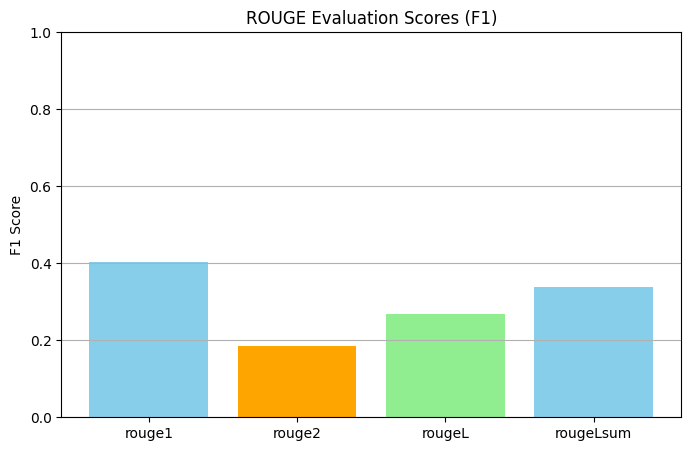


ROUGE1:
  Precision: 0.3965
  Recall:    0.4527
  F1 Score:  0.4027

ROUGE2:
  Precision: 0.1832
  Recall:    0.2068
  F1 Score:  0.1848

ROUGEL:
  Precision: 0.2654
  Recall:    0.3028
  F1 Score:  0.2694

ROUGELSUM:
  Precision: 0.3339
  Recall:    0.3775
  F1 Score:  0.3376


In [36]:
import matplotlib.pyplot as plt

scores = {key: results[key].mid.fmeasure for key in results.keys()}

# Bar Chart
plt.figure(figsize=(8, 5))
plt.bar(scores.keys(), scores.values(), color=["skyblue", "orange", "lightgreen"])
plt.title("ROUGE Evaluation Scores (F1)")
plt.ylabel("F1 Score")
plt.ylim(0, 1)
plt.grid(axis="y")
plt.show()

# Print all scores
for key, score in results.items():
    print(f"\n{key.upper()}:\n"
          f"  Precision: {score.mid.precision:.4f}\n"
          f"  Recall:    {score.mid.recall:.4f}\n"
          f"  F1 Score:  {score.mid.fmeasure:.4f}")


In [37]:
import pandas as pd

# Create summary table
summary_df = pd.DataFrame({
    "Article": articles,
    "Reference Summary": references,
    "Predicted Summary": predictions,
    "Ref Length": [len(ref.split()) for ref in references],
    "Pred Length": [len(pred.split()) for pred in predictions],
})

# Add compression ratio
summary_df["Compression Ratio"] = summary_df["Pred Length"] / summary_df["Ref Length"]

# Show stats
print(summary_df[["Ref Length", "Pred Length", "Compression Ratio"]].describe())


       Ref Length  Pred Length  Compression Ratio
count  200.000000   200.000000         200.000000
mean    61.160000    63.190000           1.193233
std     33.748172    18.969531           0.513773
min     21.000000    19.000000           0.156658
25%     41.000000    49.000000           0.793608
50%     54.000000    63.000000           1.113942
75%     73.250000    76.250000           1.521372
max    383.000000   105.000000           2.523810


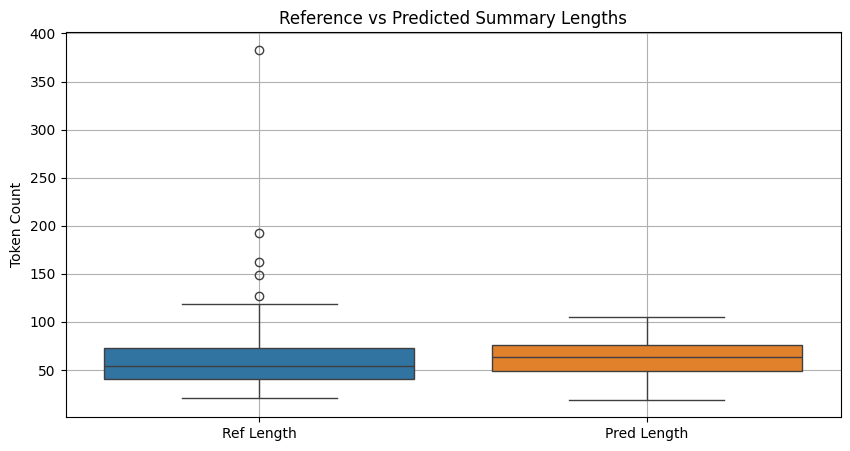

In [38]:
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.boxplot(data=summary_df[["Ref Length", "Pred Length"]])
plt.title("Reference vs Predicted Summary Lengths")
plt.ylabel("Token Count")
plt.grid(True)
plt.show()


In [19]:
model_path = "./t5_summarizer_model"
model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)


('./t5_summarizer_model/tokenizer_config.json',
 './t5_summarizer_model/special_tokens_map.json',
 './t5_summarizer_model/spiece.model',
 './t5_summarizer_model/added_tokens.json')

In [20]:
model_path = "/content/drive/MyDrive/t5_summarizer_model"
model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)


('/content/drive/MyDrive/t5_summarizer_model/tokenizer_config.json',
 '/content/drive/MyDrive/t5_summarizer_model/special_tokens_map.json',
 '/content/drive/MyDrive/t5_summarizer_model/spiece.model',
 '/content/drive/MyDrive/t5_summarizer_model/added_tokens.json')

In [21]:
import gradio as gr

In [22]:
# Load from your saved directory
model = T5ForConditionalGeneration.from_pretrained("./t5_summarizer_model")
tokenizer = T5Tokenizer.from_pretrained("./t5_summarizer_model")

# Define prediction function
def summarize_article(text, max_input_len, max_summary_len, beam_width):
    input_text = "summarize: " + text.strip()
    input_ids = tokenizer.encode(input_text, return_tensors="pt", truncation=True, padding="max_length", max_length=max_input_len)
    output_ids = model.generate(
        input_ids,
        max_length=max_summary_len,
        num_beams=beam_width,
        repetition_penalty=1.5,
        length_penalty=1.0,
        no_repeat_ngram_size=2,
        early_stopping=True
    )
    return tokenizer.decode(output_ids[0], skip_special_tokens=True)

# Launch the fancy Gradio UI
gr.Interface(
    fn=summarize_article,
    inputs=[
        gr.Textbox(label="📰 Input Article", lines=15, placeholder="Paste article here..."),
        gr.Slider(128, 1024, value=512, step=64, label="📏 Max Input Length"),
        gr.Slider(32, 256, value=128, step=16, label="📝 Max Summary Length"),
        gr.Slider(1, 8, value=4, step=1, label="🔍 Beam Width")
    ],
    outputs=gr.Textbox(label="🧠 Generated Summary"),
    title="T5-Small Summarizer 🧠",
    description="Custom fine-tuned news summarizer built on T5-Small. Paste long text and tweak generation parameters.",
    theme="soft",
    examples=[
        ["The US economy expanded at a 3% annual rate...", 512, 128, 4],
        ["Scientists discovered a new species of frog...", 512, 64, 2]
    ]
).launch(share=True)  # use share=True for public link (Colab only)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://fd428b023e0131498c.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
